In [1]:
import torch
import torchvision.models as models
import torchvision.transforms as transforms
from configparser import ConfigParser
from tqdm import tqdm
import re
import time
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
import os
import glob
import random
import numpy as np
import shutil
# import faiss
from openai import OpenAI
import os
import base64
import json
from io import BytesIO
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, classification_report,precision_recall_fscore_support
import json

# Data

In [5]:
train_dir = "/content/drive/MyDrive/Binary_classification_using_LLMs/train_test dataset (1000)/train"
test_dir =  "/content/drive/MyDrive/Binary_classification_using_LLMs/train_test dataset (1000)/test"

# train_dir = "/content/drive/MyDrive/Binary_classification_using_LLMs/var_normal merged lesion train_test dataset (1000)/train"
# test_dir =  "/content/drive/MyDrive/Binary_classification_using_LLMs/var_normal merged lesion train_test dataset (1000)/test"



In [6]:
def get_data(root_directory):
    image_text_pairs = []
    # for label in os.listdir(root_directory):
    for label in ["normal", "lesion"]:
      label_dir = os.path.join(root_directory, label)
      if os.path.isdir(label_dir):
        # Iterate through each image in the label directory
        for image_file in os.listdir(label_dir):
            image_path = os.path.join(label_dir, image_file)
            # Check if the path is a file (to avoid subdirectories)
            if os.path.isfile(image_path):
                # Add the image path and label to the list
                image_text_pairs.append((image_path, label))
    return image_text_pairs

In [7]:
test_df = pd.DataFrame(get_data(test_dir), columns=['image path','label'])
test_df

,image path,label
0,/content/drive/MyDrive/Binary_classification_u...,normal
1,/content/drive/MyDrive/Binary_classification_u...,normal
2,/content/drive/MyDrive/Binary_classification_u...,normal
3,/content/drive/MyDrive/Binary_classification_u...,normal
4,/content/drive/MyDrive/Binary_classification_u...,normal
...,...,...
249,/content/drive/MyDrive/Binary_classification_u...,lesion
250,/content/drive/MyDrive/Binary_classification_u...,lesion
251,/content/drive/MyDrive/Binary_classification_u...,lesion
252,/content/drive/MyDrive/Binary_classification_u...,lesion


In [8]:
train_df = pd.DataFrame(get_data(train_dir), columns=['image path','label'])
train_df

,image path,label
0,/content/drive/MyDrive/Binary_classification_u...,normal
1,/content/drive/MyDrive/Binary_classification_u...,normal
2,/content/drive/MyDrive/Binary_classification_u...,normal
3,/content/drive/MyDrive/Binary_classification_u...,normal
4,/content/drive/MyDrive/Binary_classification_u...,normal
...,...,...
585,/content/drive/MyDrive/Binary_classification_u...,lesion
586,/content/drive/MyDrive/Binary_classification_u...,lesion
587,/content/drive/MyDrive/Binary_classification_u...,lesion
588,/content/drive/MyDrive/Binary_classification_u...,lesion


# Retriever

In [20]:
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"

def get_image_encoder():
    resnet50 = models.resnet50(pretrained=True)
    resnet50 = torch.nn.Sequential(*list(resnet50.children())[:-1])  # Remove classification layer
    resnet50.eval()
    return resnet50


def extract_number_from_filename(file_path):
    # Get the file name from the path
    file_name = os.path.basename(file_path)

    # Use regular expressions to find all numbers in the file name
    match = re.search(r'\d+', file_name)
    return int(match.group())


def get_preprocessor():
    preprocess = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])
    return preprocess

def cosine_similarity(a, b):
    # print(a.shape)
    # print(b.shape)
    a_norm = np.linalg.norm(a, axis=1, keepdims=True)
    b_norm = np.linalg.norm(b, axis=1, keepdims=True)
    return np.dot(a, b.T) / (a_norm * b_norm)
# def cosine_similarity(a, b):
#     a = np.atleast_2d(a)
#     b = np.atleast_2d(b)

#     a_norm = np.linalg.norm(a, axis=1, keepdims=True)
#     b_norm = np.linalg.norm(b, axis=1, keepdims=True)

#     # Avoid division by zero
#     a_norm[a_norm == 0] = 1e-10
#     b_norm[b_norm == 0] = 1e-10

#     similarity = np.dot(a, b.T) / (a_norm * b_norm)

#     # Clip to ensure the range is [-1, 1]
#     return similarity


class Retriever:
    def __init__(self,dataset,skip_list=None):
        # Load the pre-trained ResNet50 model without the top layer (for feature extraction)
        self.dataset = dataset
        self.skip_list = skip_list
        self.model = get_image_encoder()
        self.preprocessor = get_preprocessor()
        self.lesion_embeddings_df = None
        self.lesion_paths = []
        self.normal_embeddings_df = None
        self.normal_paths = []
        self.index_lesion = None
        self.index_normal = None
        self.top_5_lesion_df = []
        self.top_5_normal_df = []
        self.normal_embeddings_path = "/content/drive/MyDrive/Binary_classification_using_LLMs/RAG (cosine)/Embeddings/normla_embeddings(no_var).pkl"
        self.lesion_embeddings_path = "/content/drive/MyDrive/Binary_classification_using_LLMs/RAG (cosine)/Embeddings/lesion_embeddings.pkl"
        self.dimension = None

    def extract_embedding(self,image_path):
      img = Image.open(image_path)
      img = self.preprocessor(img).unsqueeze(0)  # Add batch dimension
      with torch.no_grad():
          embedding = self.model(img)
      return embedding.squeeze().numpy()

    def generate_embeddings(self,label):
        embeddings = []
        label_df = self.dataset[self.dataset["label"]==label]
        label_df.reset_index(inplace=True)
        print("Generating embdeddibgs of "+label+" images....")
        # print(label_df.index)
        # print(label_df.shape)
        for idx in tqdm(label_df.index):
            # print(idx)
            img_path = label_df.iloc[idx]["image path"]
            embedding = self.extract_embedding(img_path)
            embeddings.append(np.array(embedding))
        label_df["embeddings"] = embeddings
        return label_df

    # def get_embeddings(self):

    #     self.lesion_embeddings_df = self.generate_embeddings("lesion")
    #     self.normal_embeddings_df = self.generate_embeddings("normal")

    # def save_embeddings_to_csv(self,dir_path):
    #     self.lesion_embeddings_df.to_pickle(self.lesion_embeddings_path)
    #     self.normal_embeddings_df.to_pickle(self.normal_embeddings_path)

    def load_ebmbeddings(self):
        # Check and load or generate lesion embeddings
        if os.path.exists(self.lesion_embeddings_path):
            print("Lesion embeddings file found. Loading embeddings...")
            self.lesion_embeddings_df = pd.read_pickle(self.lesion_embeddings_path)
        else:
            print("Lesion embeddings file not found. Generating embeddings...")
            self.lesion_embeddings_df = self.generate_embeddings("lesion")
            self.lesion_embeddings_df.to_pickle(self.lesion_embeddings_path)

        # Check and load or generate normal embeddings
        if os.path.exists(self.normal_embeddings_path):
            print("Normal embeddings file found. Loading embeddings...")
            self.normal_embeddings_df = pd.read_pickle(self.normal_embeddings_path)
        else:
            print("Normal embeddings file not found. Generating embeddings...")
            self.normal_embeddings_df = self.generate_embeddings("normal")
            self.normal_embeddings_df.to_pickle(self.normal_embeddings_path)

    # Function to perform a similarity search and retrieve top 10 images
    def retrieve_top_k_images(self, query_image_path, embeddings_df,k=5):
        image_paths = embeddings_df["image path"]

        embeddings = np.vstack(embeddings_df["embeddings"].values)


        # embeddings = np.expand_dims(embeddings, axis=0)

        query_embedding = self.extract_embedding(query_image_path)
        query_embedding = np.expand_dims(query_embedding, axis=0)

        similarities = cosine_similarity(query_embedding, embeddings)

        # Get the top-k indices based on similarity scores
        top_k_indices = np.argsort(similarities[0])[::-1][:k]  # Sort in descending order

        # Retrieve the corresponding image paths and similarities
        top_k_images = [image_paths[i] for i in top_k_indices]
        top_k_similarities = [similarities[0][i] for i in top_k_indices]

        top_k_dict = {
            "top k images":top_k_images,
            "top_k_similarities": top_k_similarities
        }
        top_k_df=  pd.DataFrame(top_k_dict)
        return top_k_df


    # Retrieve top 5 images from Class A and Class B for a given query image
    def retrieve_images(self, query_image_path):
        self.top_5_lesion_df = self.retrieve_top_k_images(query_image_path, self.lesion_embeddings_df, k=15)
        self.top_5_normal_df = self.retrieve_top_k_images(query_image_path, self.normal_embeddings_df, k=15)
        return query_image_path, self.top_5_lesion_df, self.top_5_normal_df

In [21]:
retriever = Retriever(dataset = train_df)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [22]:
retriever.load_ebmbeddings()

Lesion embeddings file found. Loading embeddings...
Normal embeddings file found. Loading embeddings...


In [23]:
len(retriever.lesion_embeddings_df.iloc[0]["embeddings"])

2048

In [24]:
random_test_img = test_df["image path"][random.randint(0,200)]

In [25]:
random_test_img

'/content/drive/MyDrive/Binary_classification_using_LLMs/train_test dataset (1000)/test/normal/CHCI_20.jpg'

In [26]:
query_image_path, top_5_lesion_df, top_5_normal_df = retriever.retrieve_images(random_test_img)

In [27]:
top_5_normal_df

,top k images,top_k_similarities
0,/content/drive/MyDrive/Binary_classification_u...,1.211272
1,/content/drive/MyDrive/Binary_classification_u...,1.166560
2,/content/drive/MyDrive/Binary_classification_u...,1.155626
3,/content/drive/MyDrive/Binary_classification_u...,1.152489
4,/content/drive/MyDrive/Binary_classification_u...,1.145582
5,/content/drive/MyDrive/Binary_classification_u...,1.143362
6,/content/drive/MyDrive/Binary_classification_u...,1.123231
7,/content/drive/MyDrive/Binary_classification_u...,1.113891
8,/content/drive/MyDrive/Binary_classification_u...,1.113218
9,/content/drive/MyDrive/Binary_classification_u...,1.109311


In [29]:
top_5_lesion_df

,top k images,top_k_similarities
0,/content/drive/MyDrive/Binary_classification_u...,1.138310
1,/content/drive/MyDrive/Binary_classification_u...,1.010071
2,/content/drive/MyDrive/Binary_classification_u...,0.993917
3,/content/drive/MyDrive/Binary_classification_u...,0.979481
4,/content/drive/MyDrive/Binary_classification_u...,0.961225
5,/content/drive/MyDrive/Binary_classification_u...,0.960561
6,/content/drive/MyDrive/Binary_classification_u...,0.952873
7,/content/drive/MyDrive/Binary_classification_u...,0.947797
8,/content/drive/MyDrive/Binary_classification_u...,0.938038
9,/content/drive/MyDrive/Binary_classification_u...,0.937957


In [28]:
def show_top_k_images(query_image_path, top_lesion_images, top_normal_images,k=5):
    # Load the query image
    query_image = Image.open(query_image_path)

    # Define figure layout based on the number of top images to display
    fig, axes = plt.subplots(3, k, figsize=(5 * k, 20))

    # Show the query image in the top row
    axes[0, 0].imshow(query_image)
    axes[0, 0].set_title("Query Image")
    axes[0, 0].axis("off")

    # Fill the rest of the top row with empty plots if k > 1
    skip_axes = [0,1,3,4]
    for ax in axes[0, 1:]:
        ax.axis("off")

    # Display top lesion images in the second row
    for i, lesion_img_path in enumerate(top_lesion_images[:k]):
        lesion_img = Image.open(lesion_img_path)
        axes[1, i].imshow(lesion_img)
        axes[1, i].set_title(f"Lesion Image {i + 1}")
        axes[1, i].axis("off")

    # Display top normal images in the third row
    for i, normal_img_path in enumerate(top_normal_images[:k]):
        normal_img = Image.open(normal_img_path)
        axes[2, i].imshow(normal_img)
        axes[2, i].set_title(f"Normal Image {i + 1}")
        axes[2, i].axis("off")

    # Adjust layout to avoid overlap
    plt.tight_layout()
    plt.show()

In [ ]:
# show_top_k_images(query_image_path, top_5_lesion_df["top k images"].values, top_5_normal_df["top k images"].values, k=5)

# Data Processor

In [30]:
def to_base64(path):
    with open(path, 'rb') as image_file:
        image_base64 = base64.b64encode(image_file.read()).decode('utf-8')
    return image_base64

class Processor:
    def __init__(self, lesion_image_list, test_image_path, max_size, normal_image_list=None):
        if normal_image_list is None:
            normal_image_list = []
        self.lesion_image_list = lesion_image_list
        self.normal_image_list = normal_image_list
        self.max_size = max_size
        self.test_image = test_image_path
        # self.lesion_descriptions = get_lesion_description()
        self.messages = None

    def get_image_data(self, img_path):
        return self.resize_and_convert_to_base64(img_path)

    def resize_and_convert_to_base64(self, image_path):
        size = self.max_size
        # Open the image file
        with Image.open(image_path) as img:
            # Check the size of the image
            width, height = img.size

            # Resize if either dimension is greater than 800 pixels
            if width > size or height > size:
                # Determine the new size while maintaining the aspect ratio
                if width > height:
                    new_width = size
                    new_height = int((size / width) * height)
                else:
                    new_height = size
                    new_width = int((size / height) * width)

                # Resize the image
                img = img.resize((new_width, new_height), Image.Resampling.LANCZOS)

            # Convert the image to base64
            buffered = BytesIO()
            img.save(buffered, format="PNG")
            img_base64 = base64.b64encode(buffered.getvalue()).decode("utf-8")

            return img_base64

    def get_content(self):
        content_list = [{
            "type": "text",
            "text": """Here are some images and their respective classes. Please act as an image classifier and classify the last image as either "lesion" or "normal" in the given format.
                       Respond only with either "lesion" or "normal".
                       Do not write any explanations, comments, or plain text."""
        }]
        for img_path in self.lesion_image_list:
            content_list.append(
                {
                    "type": "image_url",
                    "image_url": {
                        "url": f"data:image/jpg;base64,{self.get_image_data(img_path)}"
                    }
                }
            )
            content_list.append(
                {"type": "text", "text": "lesion"}
            )
        for img_num in self.normal_image_list:
            content_list.append(
                {
                    "type": "image_url",
                    "image_url": {
                        "url": f"data:image/jpg;base64,{self.get_image_data(img_path)}"
                    }
                }
            )
            content_list.append(
                {"type": "text", "text": "normal"}
            )


        return content_list

    def get_message(self):
        self.messages = [
            {"role": "user", "content": self.get_content()},
            {"role": "user", "content": [
                {
                    "type": "image_url",
                    "image_url": {
                        "url": f"data:image/jpg;base64,{self.get_image_data(self.test_image)}"
                    }
                }]
             }
        ]

# Augmentation and generation

In [31]:
client = OpenAI(api_key = "sk-5MnwpVvFZ_HWVNnF4hxAznHFqSTyu2FOmOl4FiXrXnT3BlbkFJ0v7MT3OHej4IkO-4Gkml1fWiqmLcxBWvWItFtkR4oA")


def predict(lesion_image_list, max_size, normal_image_list, test_image_path):
    image_processor = Processor(lesion_image_list=lesion_image_list,
                                max_size=max_size,
                                normal_image_list=normal_image_list,
                                test_image_path = test_image_path)

    image_processor.get_message()
    messages = image_processor.messages

    response = client.chat.completions.create(
        model='gpt-4o-2024-08-06',
        messages=messages,
        temperature=0.0,
        max_tokens=200
    )

    return response.choices[0].message.content

In [36]:
test_image_list = test_df["image path"]

max_size = 200
num_examples = 5

results = {}

num_runs = 1

for run in range(num_runs):
  print(f"Run {run+1} of {num_runs}")
  results[f"Run{run+1}"] = {}
  for idx in tqdm(test_df.index):
  # for idx in tqdm(range(10)):
      expectation = test_df["label"][idx]
      test_image_path = test_df["image path"][idx]
      query_image_path, top_5_lesion_images, top_5_normal_images= retriever.retrieve_images(test_image_path)
      lesion_img_list = top_5_lesion_images["top k images"].values
      normal_img_list = top_5_normal_images["top k images"].values


      test_image_name = query_image_path[94:]
      prediction = predict(lesion_image_list=lesion_img_list,
                            max_size=max_size,
                            normal_image_list=normal_img_list,
                          test_image_path = query_image_path
                          )

      results[f"Run{run+1}"][test_image_name] = {
          "query_image_path": query_image_path,
          "expectation": expectation,
          "prediction": prediction,
      }
  # Save a checkpoint after each run with a descriptive filename
  checkpoint_path = f"/content/drive/MyDrive/Binary_classification_using_LLMs/RAG (cosine)/Results/Result_after_run_{run + 1}_15_15(no var).json"
  # # checkpoint_path = f"/content/drive/MyDrive/Binary_classification_using_LLMs/RAG (cosine)/Results/Result_of_imbalance_few_shot.json"
  with open(checkpoint_path, "w") as outfile:
      json.dump(results, outfile)
  print(f"Checkpoint saved. Data available up to Run {run + 1}")

Run 1 of 1


100%|██████████| 254/254 [46:52<00:00, 11.07s/it]

Checkpoint saved. Data available up to Run 1


# Results

In [37]:
# with open(f"/content/drive/MyDrive/Binary_classification_using_LLMs/RAG (cosine)/Results/Result_of_imbalance_few_shot.json", 'r') as file:
#     results = json.load(file)

with open(f"/content/drive/MyDrive/Binary_classification_using_LLMs/RAG (cosine)/Results/Result_after_run_{1}_15_15(no var).json", 'r') as file:
    results = json.load(file)

# with open(f"/content/drive/MyDrive/Binary_classification_using_LLMs/RAG (cosine)/Results/Result_after_run_{1}(var_merged_lesion).json", 'r') as file:
#     results = json.load(file)

# with open(f"/content/drive/MyDrive/Binary_classification_using_LLMs/RAG (cosine)/Results/Result_after_run_{1}.json", 'r') as file:
#     results = json.load(file)


Processing images for Run1: 100%|██████████| 254/254 [00:00<00:00, 299930.52it/s]


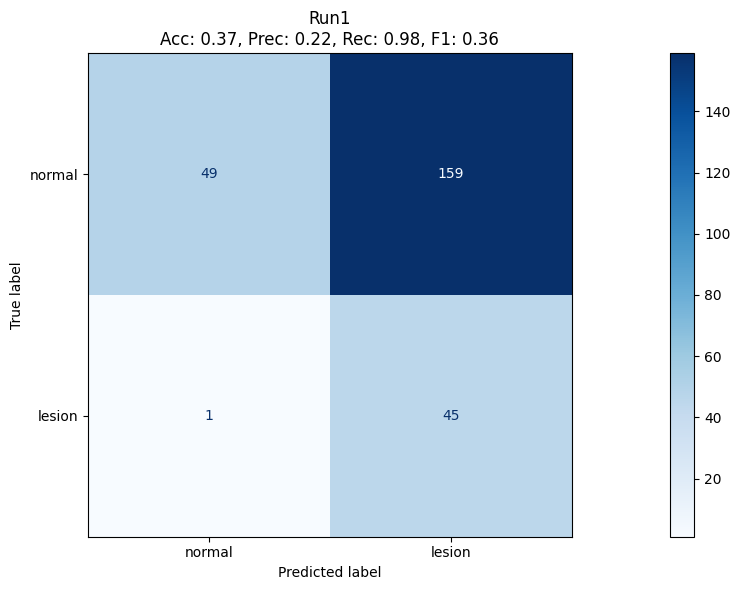

In [38]:
import json
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, precision_score, recall_score, f1_score
from tqdm import tqdm

# Define class mappings
class_mapping = {"normal": 0,"lesion": 1}

# Prepare a figure for subplots
num_runs = len(results)
fig, axes = plt.subplots(1, num_runs, figsize=(20 * num_runs, 6), sharey=True)

metrics = {}

# Process results for each run
for idx, (run_name, run_data) in enumerate(results.items()):
    # Initialize lists for actual and prediction values
    actual = []
    prediction = []
    unknown_classes = []
    metrics[run_name] = {}

    # Process each image in the run
    for img, data in tqdm(run_data.items(), desc=f"Processing images for {run_name}"):
        actual_class = data["expectation"]
        pred_class = data["prediction"]

        if pred_class not in class_mapping:
            unknown_classes.append((img, actual_class, pred_class))
            print(f"Unknown class in prediction: {pred_class}")
            continue

        else:
            pred_label = class_mapping[pred_class]
            prediction.append(pred_label)
            actual_label = class_mapping[actual_class]
            actual.append(actual_label)

    # Compute metrics
    accuracy = accuracy_score(actual, prediction)
    precision = precision_score(actual, prediction, average='binary', pos_label=class_mapping["lesion"])
    recall = recall_score(actual, prediction, average='binary', pos_label=class_mapping["lesion"])
    f1 = f1_score(actual, prediction, average='binary', pos_label=class_mapping["lesion"])

    metrics[run_name] = {
        "accuracy": accuracy,
        "precision": precision,
        "recall": recall,
        "f1": f1,
        "unknown_classes": unknown_classes
    }
    # Compute confusion matrix
    matrix = confusion_matrix(actual, prediction)

    # Plot confusion matrix in a subplot
    ax = axes[idx] if num_runs > 1 else axes
    cm_display = ConfusionMatrixDisplay(confusion_matrix=matrix, display_labels=list(class_mapping.keys()))
    cm_display.plot(cmap=plt.cm.Blues, ax=ax)
    ax.set_title(
        f"{run_name}\n"
        f"Acc: {accuracy:.2f}, Prec: {precision:.2f}, Rec: {recall:.2f}, F1: {f1:.2f}"
    )

# Adjust layout and show the plot
plt.tight_layout()
plt.show()

In [ ]:
# import json
# import matplotlib.pyplot as plt
# from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, precision_score, recall_score, f1_score
# from tqdm import tqdm

# # Define class mappings
# class_mapping = {"lesion": 1, "normal": 0}

# # Check if results are available
# if not results:
#     raise ValueError("No results available for processing.")

# # Prepare a figure for subplots
# num_runs = len(results)
# fig, axes = plt.subplots(1, num_runs, figsize=(5 * num_runs, 6), sharey=True)

# metrics = {}

# # Process results for each run
# for idx, (run_name, run_data) in enumerate(results.items()):
#     # Initialize lists for actual and prediction values
#     actual = []
#     prediction = []
#     unknown_classes = []
#     metrics[run_name] = {}

#     # Process each image in the run
#     for img, data in tqdm(run_data.items(), desc=f"Processing images for {run_name}"):
#         actual_class = data.get("expectation")
#         pred_class = data.get("prediction")

#         if pred_class not in class_mapping:
#             unknown_classes.append((img, actual_class, pred_class))
#             print(f"Unknown class in prediction: {pred_class}")
#             continue

#         pred_label = class_mapping[pred_class]
#         prediction.append(pred_label)
#         actual_label = class_mapping.get(actual_class)
#         if actual_label is not None:
#             actual.append(actual_label)

#     # Compute metrics
#     accuracy = accuracy_score(actual, prediction)
#     precision = precision_score(actual, prediction, average='binary', pos_label=class_mapping["lesion"])
#     recall = recall_score(actual, prediction, average='binary', pos_label=class_mapping["lesion"])
#     f1 = f1_score(actual, prediction, average='binary', pos_label=class_mapping["lesion"])

#     metrics[run_name] = {
#         "accuracy": accuracy,
#         "precision": precision,
#         "recall": recall,
#         "f1": f1,
#         "unknown_classes": unknown_classes
#     }
#     # Compute confusion matrix
#     matrix = confusion_matrix(actual, prediction)

#     # Plot confusion matrix in a subplot
#     ax = axes[idx] if num_runs > 1 else axes
#     cm_display = ConfusionMatrixDisplay(confusion_matrix=matrix, display_labels=list(class_mapping.keys()))
#     cm_display.plot(cmap=plt.cm.Blues, ax=ax)
#     ax.set_title(
#         f"{run_name}\n"
#         f"Acc: {accuracy:.2f}, Prec: {precision:.2f}, Rec: {recall:.2f}, F1: {f1:.2f}"
#     )

# # Adjust layout and show the plot
# plt.tight_layout()
# plt.show()


In [ ]:
!pip install xlsxwriter

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 159.9/159.9 kB 4.0 MB/s eta 0:00:00


In [ ]:
import json
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, precision_score, recall_score, f1_score
from tqdm import tqdm
import pandas as pd
import xlsxwriter

# Define class mappings
class_mapping = {"normal": 1,"lesion": 0}

# Prepare an Excel writer
output_file = "/content/drive/MyDrive/Binary_classification_using_LLMs/RAG (cosine)/Results/Result_of_without_var_nomral.xlsx"
writer = pd.ExcelWriter(output_file, engine="xlsxwriter")

# Process results for each run
for run_name, run_data in results.items():
    print(f"Processing {run_name}...")

    # Initialize lists for actual, prediction, and misclassification
    actual = []
    prediction = []
    false_positives = []
    false_negatives = []
    unknown_classes = []

    # Process each image
    for img_path, data in tqdm(run_data.items(), desc=f"Processing images for {run_name}"):
        actual_class = data["expectation"]
        pred_class = data["prediction"]
        query_image_path = data["query_image_path"]

        if pred_class not in class_mapping or actual_class not in class_mapping:
            unknown_classes.append((query_image_path, actual_class, pred_class))
            continue

        actual_label = class_mapping[actual_class]
        pred_label = class_mapping[pred_class]
        actual.append(actual_label)
        prediction.append(pred_label)

        # Classify misclassifications
        if actual_label != pred_label:
            if pred_label == class_mapping["lesion"]:
                false_positives.append(query_image_path)  # Predicted lesion, but actual is normal
            else:
                false_negatives.append(query_image_path)  # Predicted normal, but actual is lesion

    # Save false positives and false negatives to a DataFrame
    misclass_df = pd.DataFrame({
        "False Positives (Image Path)": false_positives + [""] * (len(false_negatives) - len(false_positives)),
        "False Negatives (Image Path)": false_negatives + [""] * (len(false_positives) - len(false_negatives))
    })
    misclass_df.to_excel(writer, sheet_name=f"{run_name}_Misclassifications", index=False)

    # Save unknown classes to a DataFrame
    unknown_df = pd.DataFrame(unknown_classes, columns=["Image Path", "Expectation", "Prediction"])
    if not unknown_df.empty:
        unknown_df.to_excel(writer, sheet_name=f"{run_name}_Unknown", index=False)

# Save the Excel file
writer.close()
print(f"Results saved to {output_file}.")

Processing Run1...


Processing images for Run1: 100%|██████████| 254/254 [00:00<00:00, 204051.56it/s]

Results saved to /content/drive/MyDrive/Binary_classification_using_LLMs/RAG (cosine)/Results/Result_of_without_var_nomral.xlsx.


In [ ]:
import os
import shutil
import pandas as pd

# Input Excel file path (generated from the previous script)
input_excel_file = "/content/drive/MyDrive/Binary_classification_using_LLMs/RAG (cosine)/Results/Result_of_without_var_nomral.xlsx"


normal_dir = "/content/drive/MyDrive/Binary_classification_using_LLMs/train_test dataset (1000)/test/normal"

# Get a list of file names without extensions
normal_list = [
    os.path.splitext(f)[0] for f in os.listdir(normal_dir)
    if os.path.isfile(os.path.join(normal_dir, f))
]

var_normal_dir = "/content/drive/MyDrive/Binary_classification_using_LLMs/train_test dataset (1000)/test/variation in normal"

var_normal_list = [
    os.path.splitext(f)[0] for f in os.listdir(var_normal_dir)
    if os.path.isfile(os.path.join(var_normal_dir, f))
]

# Directory to store misclassified images
output_dir = "/content/drive/MyDrive/Binary_classification_using_LLMs/RAG (cosine)/Results/Result_of_without_var_nomral"
os.makedirs(output_dir, exist_ok=True)

# Subdirectories for false positives and false negatives
false_positives_dir = os.path.join(output_dir, "false_positives")
false_negatives_dir = os.path.join(output_dir, "false_negatives")

# Create directories
os.makedirs(false_positives_dir, exist_ok=True)
os.makedirs(false_negatives_dir, exist_ok=True)


# fp_normal_dir = os.path.join(false_positives_dir, "normal")
# fp_variation_dir = os.path.join(false_positives_dir, "variation")
# fn_variation_dir = os.path.join(false_negatives_dir, "variation")
# fn_lesion_dir = os.path.join(false_negatives_dir, "lesion")
# os.makedirs(fp_normal_dir, exist_ok=True)
# os.makedirs(fp_variation_dir, exist_ok=True)
# os.makedirs(fn_variation_dir, exist_ok=True)
# os.makedirs(fn_lesion_dir, exist_ok=True)
# Load the Excel file
excel_data = pd.ExcelFile(input_excel_file)
sheet_list = ["Run1_Misclassifications"]
# Iterate through each sheet that contains misclassification data
for sheet_name in sheet_list:
    df = pd.read_excel(input_excel_file, sheet_name=sheet_name)

    for img_path in df["False Positives (Image Path)"].dropna():
        # if os.path.exists(img_path):  # Ensure the file exists
            # Check if the image belongs to "normal" or "variation"
        # file_name = os.path.basename(img_path)
        # if file_name in normal_list:
        #     shutil.copy(img_path, fp_normal_dir)
        # elif file_name in var_normal_list:
        #     shutil.copy(img_path, fp_variation_dir)
        # else:
        #     print(f"Warning: File not found - {img_path}")
        shutil.copy(img_path, false_positives_dir)

    # Process false negatives
    for img_path in df["False Negatives (Image Path)"].dropna():
        # if file_name in var_normal_list:
        #     shutil.copy(img_path, fn_variation_dir)
        # else:
        shutil.copy(img_path, false_negatives_dir)
print(f"Misclassified images have been stored in the '{output_dir}' directory.")


Misclassified images have been stored in the '/content/drive/MyDrive/Binary_classification_using_LLMs/RAG (cosine)/Results/Result_of_without_var_nomral' directory.
